# Variogram calculation and fitting for continental US

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation

import krige_tools
import fields
import variogram as vgm
import cov_model

In [4]:
# Analysis variables
timestamp = "2019-08-01"
timedelta = -1
n_bins = 18
fast_dist = False

In [5]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

In [7]:
# Initialize Matern model
k1 = cov_model.Matern()
k2 = cov_model.Matern()

# Dummy variables (if not fitting)
cov_guesses = [[0.3, 1.5, 1e3, 0.7], [0.9, 2.5, 600, 0.35]]
cross_guess = [0.5, 800, -0.8]

In [8]:
# Helper functions
def animate(month):
    """Update contour with new frame (each frame should be a monthly group)"""
    ax1.clear()
    ax2.clear()
    cbar1.clear()
    cbar2.clear()
    
    da_xco2 = mf.field_1.ds.xco2.isel(time=month)
    da_sif = mf.field_2.ds.sif.isel(time=month)
    
    xr.plot.imshow(
            darray=da_xco2.T,
            transform=ccrs.PlateCarree(),
            ax=ax1,
            cmap="jet",
            vmin=-2,
            center=0,
            cbar_ax=cbar1,
            cbar_kwargs={"label": "scaled process residuals"},
        )
    ax1.coastlines()
    ax1.set_extent(extents)
    ax1.set_title(f"XCO$_2$: {pd.to_datetime(da_xco2.time.values).strftime('%Y-%m')}", 
                  fontsize=14)

    xr.plot.imshow(
            darray=da_sif.T,
            transform=ccrs.PlateCarree(),
            ax=ax2,
            cmap="jet",
            vmin=-2,
            center=0,
            cbar_ax=cbar2,
            cbar_kwargs={"label": "scaled process residuals"},
        )
    ax2.coastlines()
    ax2.set_extent(extents)
    ax2.set_title(f"SIF: {pd.to_datetime(da_sif.time.values).strftime('%Y-%m')}", 
                  fontsize=14)
    
def param_labels(params, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"nu: {p[0]}\nlen_scale: {p[1]}\nrho: {p[2]}"
    else:
        return f"sigma: {p[0]}\n nu: {p[1]}\n len_scale: {p[2]}\n nugget: {p[3]}"

## Method 1

Data scaled by empirical (variogram) sill, local temporal trend and constant spatial mean removed

In [9]:
method = 1

In [11]:
# Approximate the empirical sill
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, spatial_mean="constant", fast_dist=fast_dist)
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, covario_res, _ = model.empirical_variograms(cov_guesses, cross_guess, n_bins=n_bins, shift_coords=True)

lags = vario_res["xco2"]["lag"].values
bin_width = lags[2] - lags[1]

xco2
sif
xco2:sif


Text(0.5, 0.98, 'Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n4x5-degree continental US, 2019-08-01, residuals method 1, bin width 211 km')

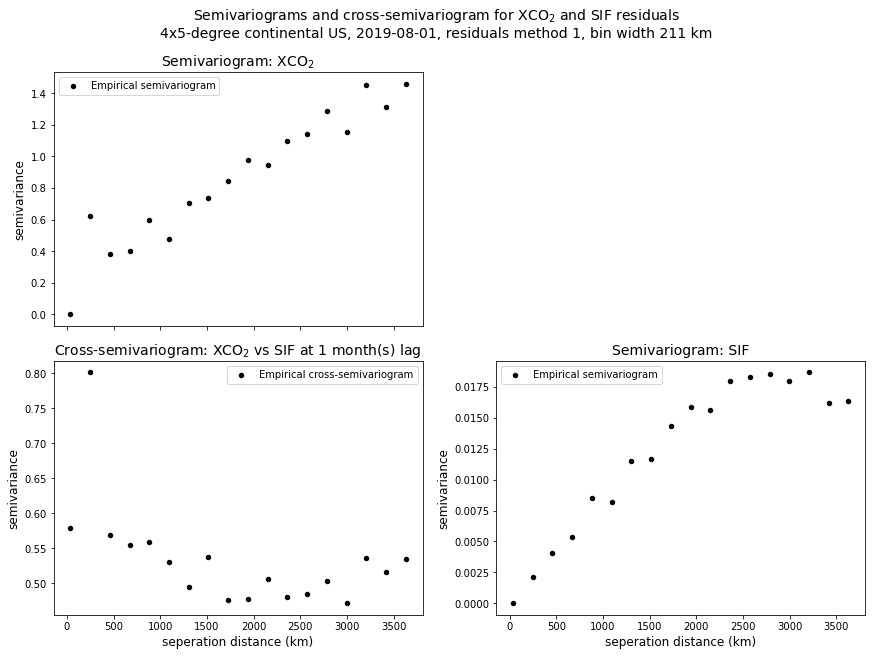

In [12]:
var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("semivariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].legend(loc="upper left")

df = vario_res[cross_name]
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-semivariogram")
ax[1, 0].set_ylabel("semivariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Semivariogram: SIF", fontsize=14)

fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14);

In [13]:
# Rescale the data
scales = [np.sqrt(1.5), np.sqrt(0.018)]
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, spatial_mean="constant", scale_facts=scales, fast_dist=fast_dist)

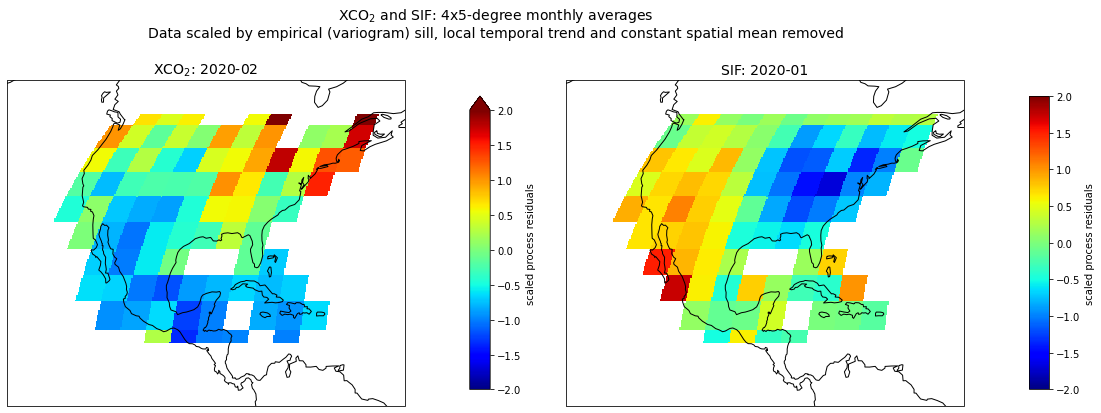

In [18]:
# Look at the data for in month in use
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 52]

ax1 = fig.add_subplot(gs[:, 0:45], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:95], projection=ccrs.EqualEarth())
cbar1 = fig.add_subplot(gs[5:95, 46:48])
cbar2 = fig.add_subplot(gs[5:95, 96:98])
    
fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly averages\n"+
    "Data scaled by empirical (variogram) sill, local temporal trend and constant spatial mean removed", 
    size=14, y=1.05
)

mov = FuncAnimation(fig, animate, frames=mf.field_1.ds.time.size, 
                    interval=500)

mov.save(f"../plots/4x5degree_monthly_avg_residuals_method{method}_about_{timestamp}.mp4", fps=2, dpi=200)

In [15]:
# Recompute variograms and plot
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, covario_res, _ = model.empirical_variograms(cov_guesses, cross_guess, n_bins=n_bins, shift_coords=True)

xco2
sif
xco2:sif
ERROR: optimization did not converge.


../src/variogram.py:486: UserWarning: ERROR: optimization did not converge.
  warnings.warn("ERROR: optimization did not converge.")


In [16]:
# Set model params manually
params = {
    "xco2": [0.84, 4.5, 1.4e3, 0.2],
    "sif": [0.88, 3.5, 1e3, 0.1],
    "xco2:sif": [4.5, 800, -0.3]
}
sigmas = [params["xco2"][0], params["sif"][0]]
nuggets = [params["xco2"][3], params["sif"][3]]

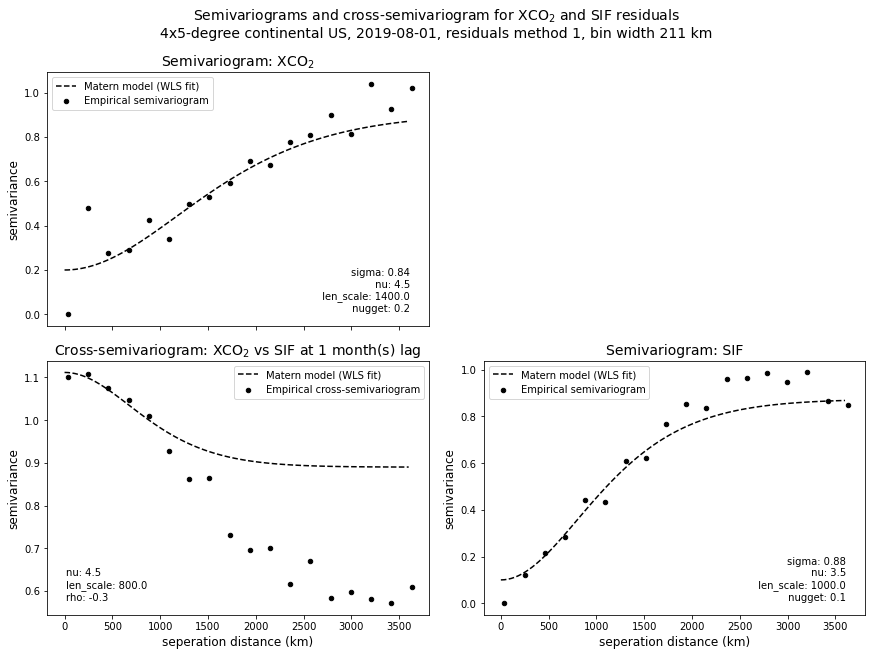

In [17]:
pred = np.linspace(0, 3600, 100)
fits = [vgm.matern_vario(pred, *params["xco2"]), vgm.matern_vario(pred, *params["sif"])]
fit_cross = vgm.matern_cross_vario(pred, sigmas, nuggets, *params[cross_name])

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
#     df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
#     ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].plot(pred, fits[i], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("semivariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.95, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="right", va="bottom")
    ax[i, i].legend(loc="upper left")

df = vario_res[cross_name]
df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-semivariogram")
# ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.05, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="left", va="bottom")
ax[1, 0].legend(loc="upper right")
ax[1, 0].set_ylabel("semivariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Semivariogram: SIF", fontsize=14)

fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)

fig.savefig(f"../plots/semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);

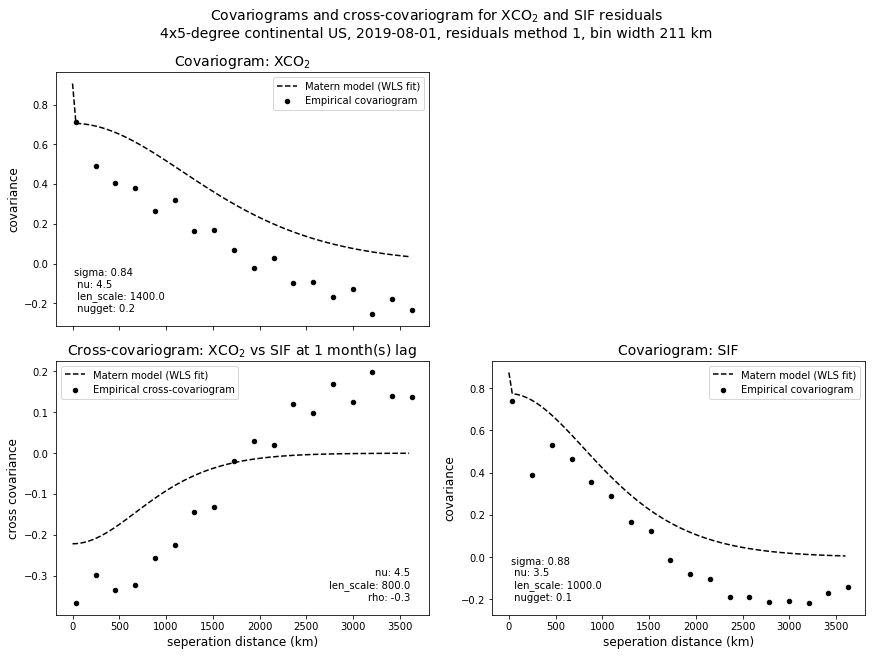

In [19]:
fits = [vgm.matern_cov(pred, *params["xco2"]), vgm.matern_cov(pred, *params["sif"])]
fit_cross = vgm.matern_cross_cov(pred, sigmas, *params[cross_name])

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = covario_res[var]
#     df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical covariogram")
#     ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].plot(pred, fits[i], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("covariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.05, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="left", va="bottom")
    ax[i, i].legend()

df = covario_res[cross_name]
# df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-covariogram")
# ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.95, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
ax[1, 0].legend(loc="upper left")
ax[1, 0].set_ylabel("cross covariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Covariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-covariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Covariogram: SIF", fontsize=14)

fig.suptitle("Covariograms and cross-covariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)

fig.savefig(f"../plots/covariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);

## Method 2

Data scaled by empirical (variogram) sill, local temporal trend and ordinary least squares spatial mean removed

In [20]:
method = 2

In [21]:
# Approximate the empirical sill
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, spatial_mean="ols", fast_dist=fast_dist)
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, covario_res, _ = model.empirical_variograms(cov_guesses, cross_guess, n_bins=n_bins, shift_coords=True)

lags = vario_res["xco2"]["lag"].values
bin_width = lags[2] - lags[1]

xco2
sif
xco2:sif


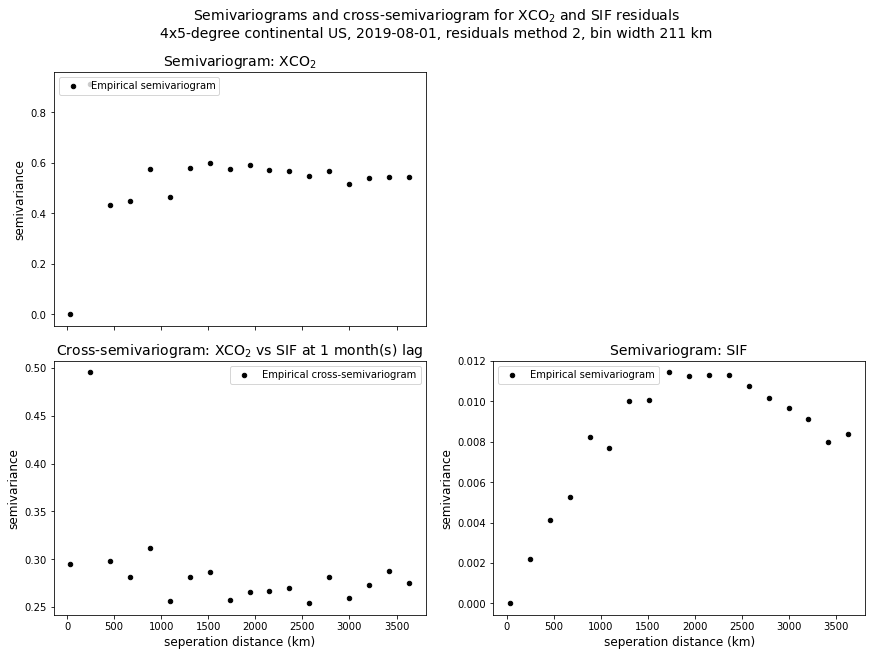

In [22]:
var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("semivariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].legend(loc="upper left")

df = vario_res[cross_name]
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-semivariogram")
ax[1, 0].set_ylabel("semivariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Semivariogram: SIF", fontsize=14)

fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14);

In [29]:
# Rescale the data
scales = [np.sqrt(0.6), np.sqrt(0.012)]
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, spatial_mean="ols", scale_facts=scales, fast_dist=fast_dist)

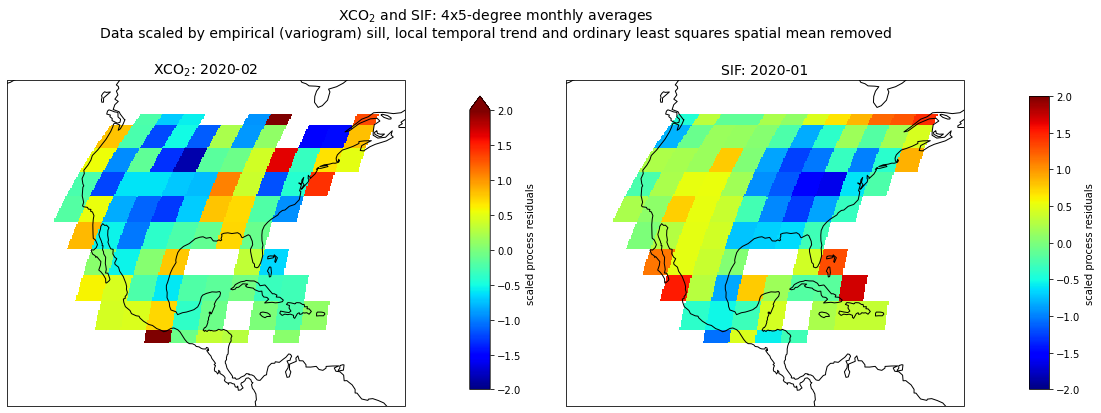

In [30]:
# Look at the data for in month in use
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 52]

ax1 = fig.add_subplot(gs[:, 0:45], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:95], projection=ccrs.EqualEarth())
cbar1 = fig.add_subplot(gs[5:95, 46:48])
cbar2 = fig.add_subplot(gs[5:95, 96:98])
    
fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly averages\n"+
    "Data scaled by empirical (variogram) sill, local temporal trend and ordinary least squares spatial mean removed", 
    size=14, y=1.05
)

mov = FuncAnimation(fig, animate, frames=mf.field_1.ds.time.size, 
                    interval=500)

mov.save(f"../plots/4x5degree_monthly_avg_residuals_method{method}_about_{timestamp}.mp4", fps=2, dpi=200)

In [31]:
# Recompute variograms and plot
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, covario_res, _ = model.empirical_variograms(cov_guesses, cross_guess, n_bins=n_bins, shift_coords=True)

xco2
sif
xco2:sif
ERROR: optimization did not converge.


../src/variogram.py:486: UserWarning: ERROR: optimization did not converge.
  warnings.warn("ERROR: optimization did not converge.")


In [49]:
# Set model params manually
params = {
    "xco2": [0.5, 4.5, 600, 0.55],
    "sif": [0.8, 4.5, 700, 0.15],
    "xco2:sif": [1.5, 900, -0.38]
}
sigmas = [params["xco2"][0], params["sif"][0]]
nuggets = [params["xco2"][3], params["sif"][3]]

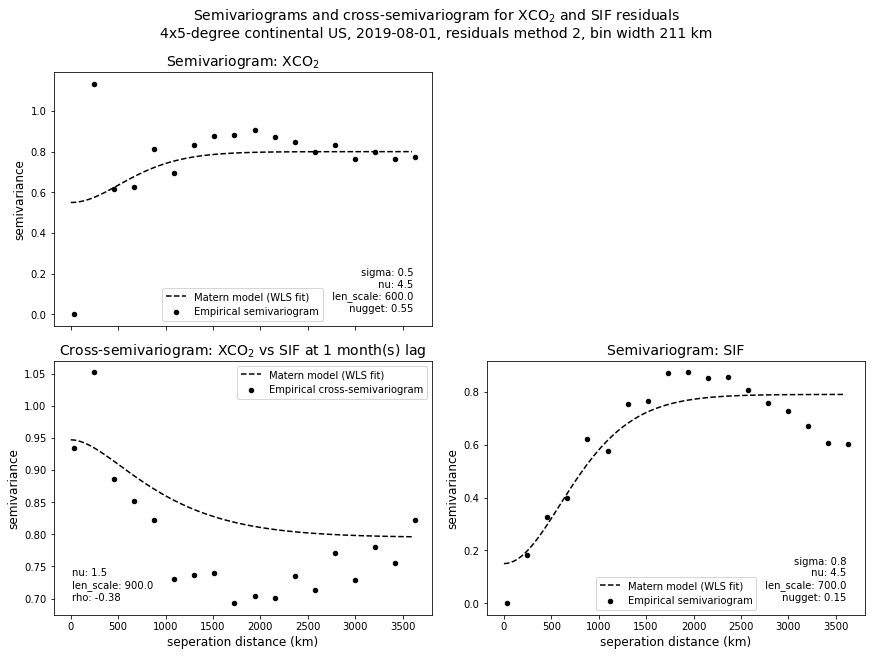

In [50]:
pred = np.linspace(0, 3600, 100)
fits = [vgm.matern_vario(pred, *params["xco2"]), vgm.matern_vario(pred, *params["sif"])]
fit_cross = vgm.matern_cross_vario(pred, sigmas, nuggets, *params[cross_name])

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
#     df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
#     ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].plot(pred, fits[i], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("semivariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.95, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="right", va="bottom")
    ax[i, i].legend(loc="lower center")

df = vario_res[cross_name]
df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-semivariogram")
# ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.05, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="left", va="bottom")
ax[1, 0].legend(loc="upper right")
ax[1, 0].set_ylabel("semivariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Semivariogram: SIF", fontsize=14)

fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)

fig.savefig(f"../plots/semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);

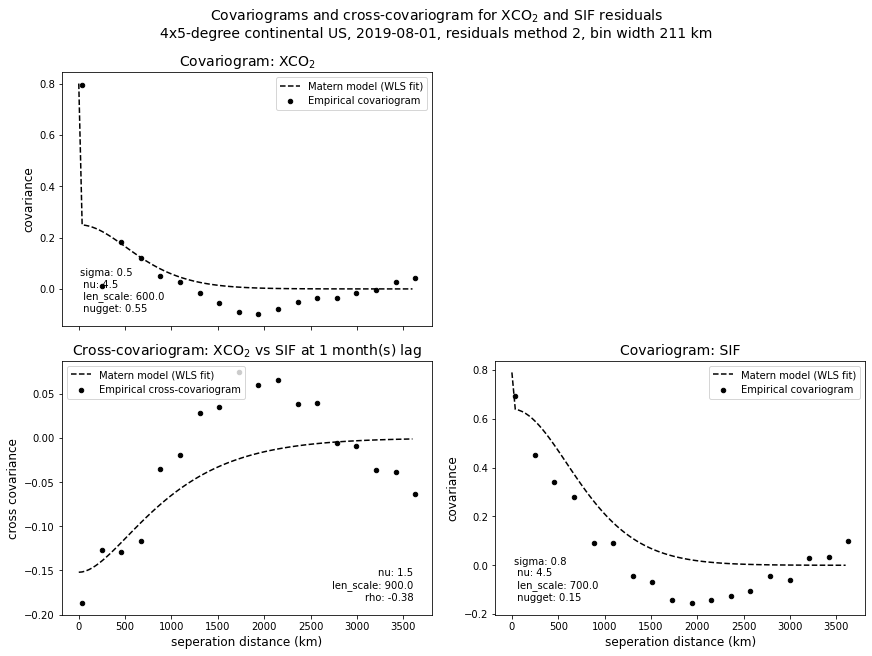

In [51]:
fits = [vgm.matern_cov(pred, *params["xco2"]), vgm.matern_cov(pred, *params["sif"])]
fit_cross = vgm.matern_cross_cov(pred, sigmas, *params[cross_name])

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = covario_res[var]
#     df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical covariogram")
#     ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].plot(pred, fits[i], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("covariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.05, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="left", va="bottom")
    ax[i, i].legend()

df = covario_res[cross_name]
# df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-covariogram")
# ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.95, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
ax[1, 0].legend(loc="upper left")
ax[1, 0].set_ylabel("cross covariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Covariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-covariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Covariogram: SIF", fontsize=14)

fig.suptitle("Covariograms and cross-covariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)

fig.savefig(f"../plots/covariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);

## Method 3

Local temporal trend and ordinary least squares spatial mean removed, data scaled by local residual standard dev.

In [52]:
method = 3

In [53]:
# Setup data
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, spatial_mean="ols", local_std=True, fast_dist=fast_dist)

../src/krige_tools.py:116: RuntimeWarning: Mean of empty slice
  custom_std = lambda x: np.sqrt(np.nanmean(x ** 2, axis=-1))
../src/krige_tools.py:116: RuntimeWarning: Mean of empty slice
  custom_std = lambda x: np.sqrt(np.nanmean(x ** 2, axis=-1))


xco2
sif
xco2:sif


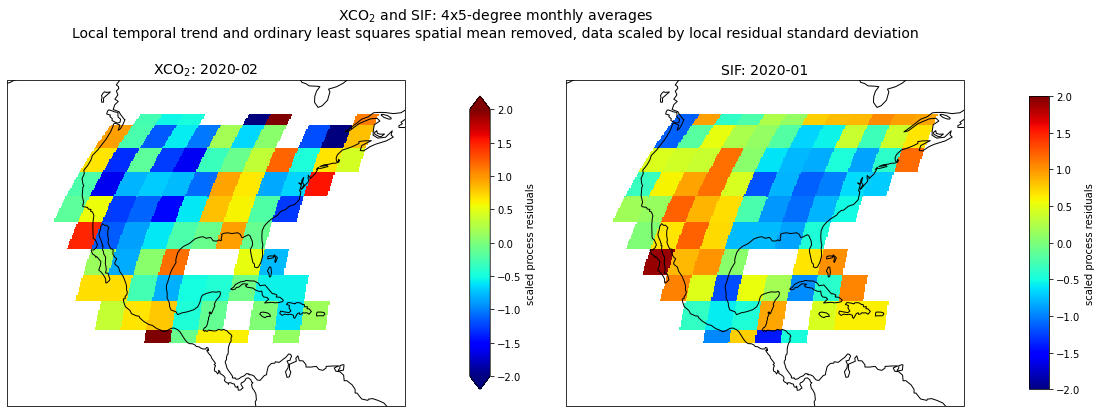

In [54]:
# Look at the data for in month in use
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 52]

ax1 = fig.add_subplot(gs[:, 0:45], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:95], projection=ccrs.EqualEarth())
cbar1 = fig.add_subplot(gs[5:95, 46:48])
cbar2 = fig.add_subplot(gs[5:95, 96:98])
    
fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly averages\n"+
    "Local temporal trend and ordinary least squares spatial mean removed, data scaled by local residual standard deviation", 
    size=14, y=1.05
)

mov = FuncAnimation(fig, animate, frames=mf.field_1.ds.time.size, 
                    interval=500)

mov.save(f"../plots/4x5degree_monthly_avg_residuals_method{method}_about_{timestamp}.mp4", fps=2, dpi=200)

In [55]:
# Compute variograms and plot
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, covario_res, _ = model.empirical_variograms(cov_guesses, cross_guess, n_bins=n_bins, shift_coords=True)

lags = vario_res["xco2"]["lag"].values
bin_width = lags[2] - lags[1]

xco2
sif
xco2:sif


In [71]:
# Set model params manually
params = {
    "xco2": [0.6, 4.5, 600, 0.7],
    "sif": [0.8, 4.5, 600, 0.35],
    "xco2:sif": [4.5, 600, -0.55]
}
sigmas = [params["xco2"][0], params["sif"][0]]
nuggets = [params["xco2"][3], params["sif"][3]]

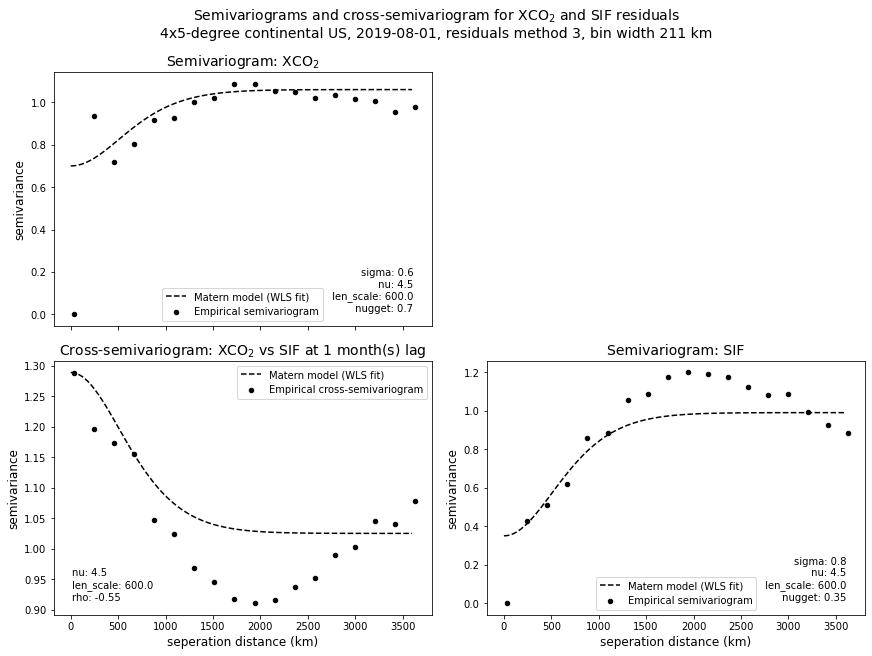

In [72]:
pred = np.linspace(0, 3600, 100)
fits = [vgm.matern_vario(pred, *params["xco2"]), vgm.matern_vario(pred, *params["sif"])]
fit_cross = vgm.matern_cross_vario(pred, sigmas, nuggets, *params[cross_name])

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
#     df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
#     ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].plot(pred, fits[i], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("semivariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.95, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="right", va="bottom")
    ax[i, i].legend(loc="lower center")

df = vario_res[cross_name]
df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-semivariogram")
# ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.05, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="left", va="bottom")
ax[1, 0].legend(loc="upper right")
ax[1, 0].set_ylabel("semivariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Semivariogram: SIF", fontsize=14)

fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)

fig.savefig(f"../plots/semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);

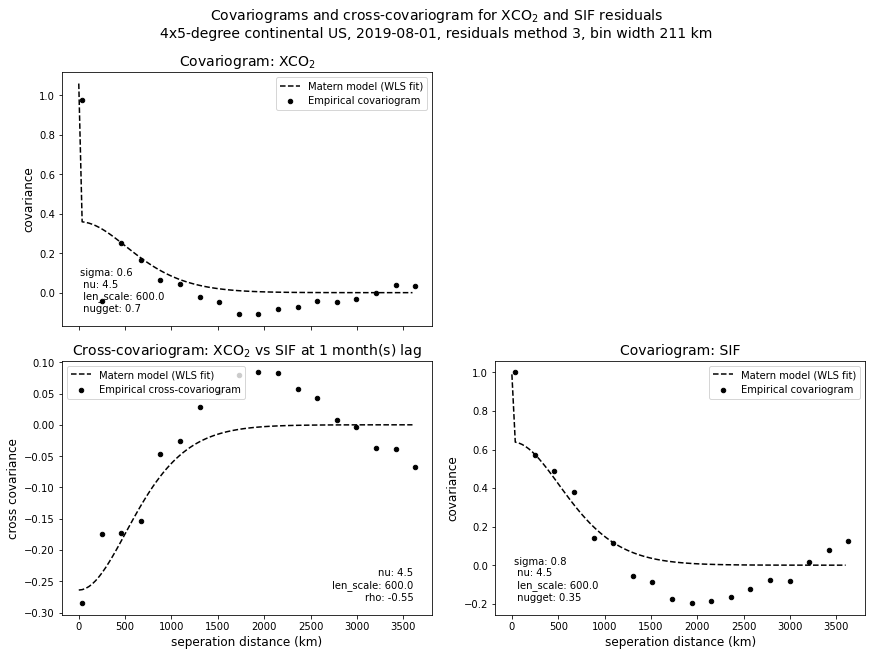

In [73]:
fits = [vgm.matern_cov(pred, *params["xco2"]), vgm.matern_cov(pred, *params["sif"])]
fit_cross = vgm.matern_cross_cov(pred, sigmas, *params[cross_name])

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = covario_res[var]
#     df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical covariogram")
#     ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].plot(pred, fits[i], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("covariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.05, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="left", va="bottom")
    ax[i, i].legend()

df = covario_res[cross_name]
# df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y=cross_name, kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-covariogram")
# ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].plot(pred, fit_cross, linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.95, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
ax[1, 0].legend(loc="upper left")
ax[1, 0].set_ylabel("cross covariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Covariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-covariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Covariogram: SIF", fontsize=14)

fig.suptitle("Covariograms and cross-covariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, residuals method {method}, bin width {np.int(bin_width)} km", fontsize=14)

fig.savefig(f"../plots/covariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag_method{method}.png", dpi=100);